# Model hiper optimization

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [125]:
# configs.
%matplotlib inline
# version to read
read_version = "1.2.b - group zone"

# model to save
model_id = "3.2.0 - only invest with zone groups f1"

pd.set_option("display.max_columns", 500)

path = "../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1 - df_train with nan.feather', '1.2.b - group zone - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to04-19.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train only 2018 without nulls.fea

## Loading training and validation datasets

In [24]:
df = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_train with nan.feather"))
df_val = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

In [25]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [26]:
# Select all non 060 tipo exped.
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
df = df[df["EXISTE_INVEST"] == True]
df_val = df_val[df_val["EXISTE_INVEST"] == True]

In [27]:
df["TIPO_EXPED"].value_counts()

6    3551
5    1342
1    1126
2     367
7     267
3     195
4     121
0      62
Name: TIPO_EXPED, dtype: int64

In [28]:
df["EXISTE_FRAUDE"].value_counts()

True     3641
False    3390
Name: EXISTE_FRAUDE, dtype: int64

In [29]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [33]:
cond_cols = df.filter(regex="^cond_*").columns
cond_cols

Index(['cond_04', 'cond_05', 'cond_06', 'cond_09', 'cond_11', 'cond_12',
       'cond_32', 'cond_37', 'cond_C1', 'cond_C10', 'cond_C11', 'cond_C12',
       'cond_C13', 'cond_C14', 'cond_C15', 'cond_C16', 'cond_C17', 'cond_C18',
       'cond_C19', 'cond_C2', 'cond_C20', 'cond_C21', 'cond_C3', 'cond_C4',
       'cond_C5', 'cond_C6', 'cond_C7', 'cond_C8', 'cond_C9'],
      dtype='object')

In [34]:
# create column number of conditions activated
df["cant_cond"] = (df[cond_cols] > 0).sum(axis=1)
df_val["cant_cond"] = (df_val[cond_cols] > 0).sum(axis=1)

In [35]:
# dropping index variables
# to_drop = ["index"]
# df.drop(to_drop, axis=1, inplace=True)
# to_drop = ["level_0", "index"]
# df_val.drop(to_drop, axis=1, inplace=True)

In [36]:
# dropping NUM_SECU_EXPED
# to_drop = ["NUM_SECU_EXPED"]
# df.drop(to_drop, axis=1, inplace=True)
# df_val.drop(to_drop, axis=1, inplace=True)

In [37]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [38]:
# using only last year
split_date = "2018-10-01"
df_train = df[df["FECHA_SINI"] < split_date].copy()
df_opt = df[df["FECHA_SINI"] >= split_date].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2017-01-01 00:00:00 2018-09-30 00:00:00
2018-10-01 00:00:00 2019-01-31 00:00:00


In [39]:
df_opt["EXISTE_FRAUDE"].value_counts()

True     704
False    575
Name: EXISTE_FRAUDE, dtype: int64

In [40]:
full_len = df_train.shape[0] + df_opt.shape[0]
df_train.shape[0] / full_len, df_opt.shape[0] / full_len

(0.8109107037256061, 0.18908929627439386)

In [41]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [42]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST", "es_gte_5"] # 

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [43]:
X_full_train = df.drop(to_drop, axis=1)
X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
y_full_train = df["EXISTE_FRAUDE"]

In [44]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [45]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

5485, 1279
5485, 1279


In [46]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.5161349134001824, 0.5504300234558248)

In [47]:
y_train.value_counts(dropna=False)

True     2831
False    2654
Name: EXISTE_FRAUDE, dtype: int64

## Defining grid configuration

In [48]:
from sklearn.utils.class_weight import compute_class_weight

In [49]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights

array([1.03702065, 0.96553145])

In [121]:
# configs
list_weights = [1, 1.2, 1.5]
[{0:1, 1:l} for l in list_weights]

[{0: 1, 1: 1}, {0: 1, 1: 1.2}, {0: 1, 1: 1.5}]

In [122]:
n_estimators = [40, 60, 100, 200]

rf_params = {
    "n_estimators": n_estimators,
    "min_samples_leaf": [3, 5, 7],
    "max_depth": [10, 40], # 10,
    "max_features": ['sqrt', None],
    "class_weight": [{0:1, 1:l} for l in list_weights],
    "bootstrap": [False, True],
}
param_configs = []
param_configs.append(rf_params)
param_configs.append(rf_params)

dt_params = {
    "min_samples_leaf": [3, 5, 7],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
#param_configs.append(dt_params)


gbt_params = {
    'n_estimators': n_estimators, 
    "max_depth": [15, 40, 5],
    'learning_rate': [1.0, 0.1, 0.05, 0.01],
#    'subsample': [0.5, 1.0],
    "colsample_bytree": [0.5 , 1.0],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)


lgbm_params = {
    'n_estimators': n_estimators, 
#    'num_leaves': [10, 20, 50],
    "max_depth": [15, 40, -1],
    'min_child_samples': [3, 5, 7, 11],
    'learning_rate': [1.0, 0.1, 0.05, 0.01],
#    'subsample': [0.5, 1.0],
    "colsample_bytree": [0.5 , 1.0],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}

param_configs.append(lgbm_params)
param_configs

[{'n_estimators': [40, 60, 100, 200],
  'min_samples_leaf': [3, 5, 7],
  'max_depth': [10, 40],
  'max_features': ['sqrt', None],
  'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 1.2}, {0: 1, 1: 1.5}],
  'bootstrap': [False, True]},
 {'n_estimators': [40, 60, 100, 200],
  'min_samples_leaf': [3, 5, 7],
  'max_depth': [10, 40],
  'max_features': ['sqrt', None],
  'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 1.2}, {0: 1, 1: 1.5}],
  'bootstrap': [False, True]},
 {'n_estimators': [40, 60, 100, 200],
  'max_depth': [15, 40, None],
  'learning_rate': [1.0, 0.1, 0.05, 0.01],
  'colsample_bytree': [0.5, 1.0],
  'scale_pos_weight': [1, 1.2, 1.5]},
 {'n_estimators': [40, 60, 100, 200],
  'max_depth': [15, 40, None],
  'min_child_samples': [3, 5, 7, 11],
  'learning_rate': [1.0, 0.1, 0.05, 0.01],
  'colsample_bytree': [0.5, 1.0],
  'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 1.2}, {0: 1, 1: 1.5}]}]

In [123]:
# using without grid with list of models
rfs = []
rfs.append(RandomForestClassifier(random_state=random_state, n_jobs=-1))
# rfs.append(DecisionTreeClassifier(random_state=random_state))
rfs.append(ExtraTreesClassifier(random_state=random_state, n_jobs=-1))
rfs.append(XGBClassifier(random_state=random_state, n_jobs=-1))
rfs.append(LGBMClassifier(random_state=random_state, silent=False, n_jobs=-1))
rfs

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators='warn',
                        n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      warm_start=False),
 XGBClassifier(ba

In [111]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt
metric = "f1"
best_models_ = []
best_scores_ = []
for counter, rf in enumerate(rfs):
    print(f"Model {counter}: {rf}")
    clf = GridSearch(rf, param_grid=param_configs[counter], seed=random_state, num_threads=1)
    clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring=metric, verbose=True)
    print(f"Best score: {clf.best_score}")
    print(f"Best config: {clf.best_params}")
    best_models_.append(copy(clf))
    best_scores_.append(clf.best_score)
    print("*-*-*-" * 10)

Model 0: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
Comparing 24 parameter setting(s) using 1 CPU thread(s) ( 24 job(s) per thread ).
Best score: 0.7625814091178211
Best config: {'learning_rate': 0.1, 'n_estimators': 60, 'scale_pos_weight': 1.5}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model 1: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=N

In [115]:
print("Best Config:")
for m, s in zip(best_models_, best_scores_):
    print(m, s)

Best Config:
GridSearch(cv_folds=3,
           model=XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bytree=1, gamma=0,
                               learning_rate=0.1, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               n_estimators=200, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1.5,
                               seed=0, silent=True, subsample=1),
           num_threads=1,
           param_grid={'learning_rate': [1.0, 0.1, 0.05, 0.01],
                       'n_estimators': [60, 200],
                       'scale_pos_weight': [1, 1.2, 1.5]},
           seed=42) 0.7625814091178211
GridSearch(cv_folds=3,
           model=LGBMClassifier(boosting_type='gbdt',
                                class_weight={0: 1, 1: 1.5},
 

In [116]:
# select best grid
best_model = best_models_[np.argmax(best_scores_)]

# select by hand
# best_model = best_models_[0]

In [117]:
sorted_ids = np.argsort(best_model.scores)
print("Grid scores:")
for i in sorted_ids[::-1]:
    print("%0.3f for %r" % (best_model.scores[i], best_model.params[i]))

Grid scores:
0.765 for {'class_weight': {0: 1, 1: 1.2}, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': None, 'min_child_samples': 11, 'n_estimators': 60, 'subsample': 1.0}
0.765 for {'class_weight': {0: 1, 1: 1.2}, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': None, 'min_child_samples': 11, 'n_estimators': 60, 'subsample': 0.5}
0.765 for {'class_weight': {0: 1, 1: 1.2}, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 40, 'min_child_samples': 11, 'n_estimators': 60, 'subsample': 1.0}
0.765 for {'class_weight': {0: 1, 1: 1.2}, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 40, 'min_child_samples': 11, 'n_estimators': 60, 'subsample': 0.5}
0.764 for {'class_weight': {0: 1, 1: 1.5}, 'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': None, 'min_child_samples': 3, 'n_estimators': 60, 'subsample': 1.0}
0.764 for {'class_weight': {0: 1, 1: 1.5}, 'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 40, 'min_child_samples': 3,

In [118]:
best_model.best_estimator_.fit(X_full_train, y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 1.5},
               colsample_bytree=0.5, importance_type='split', learning_rate=0.1,
               max_depth=None, min_child_samples=11, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [119]:
y_val_pred = best_model.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.7226386806596702, 0.6675341774644075)

In [120]:
confusion_matrix(y_val, y_val_pred)

array([[146, 117],
       [ 68, 241]])

**BEST MODEL:** <br>
LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 1.5},
               colsample_bytree=0.5, importance_type='split', learning_rate=0.1,
               max_depth=None, min_child_samples=11, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

(0.7226386806596702, 0.6675341774644075)
<br>
array([[146, 117],
       [ 68, 241]])

**Tronador**

In [64]:
y_val_tron = X_val["total_condicion"] >= 5
y_val_tron_f1_bestFI, y_val_tron_rocauc_bestFI = f1_score(y_val, y_val_tron), roc_auc_score(y_val, y_val_tron)
y_val_tron_f1_bestFI, y_val_tron_rocauc_bestFI

(0.6376811594202898, 0.6036583114917495)

In [65]:
confusion_matrix(y_val, y_val_tron)

array([[149, 114],
       [111, 198]])

In [124]:
# tipo exped analysis
tmp = X_val.copy()
tmp["EXISTE_FRAUDE"] = y_val
tmp["y_pred"] = y_val_pred
pd.crosstab(tmp["TIPO_EXPED"], [tmp["EXISTE_FRAUDE"], tmp["y_pred"] > 0.5])

EXISTE_FRAUDE False       True       
y_pred        False True  False True 
TIPO_EXPED                           
0                 3     0     2     0
1                43     0     7     0
2                 6     1     3     0
3                 3     2     2     2
4                 3     0     0     1
5                55     4    20     3
6                33   110    34   235

## dumping best current config

In [ ]:
# Current good config
"""
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
"""
# full features
# scores: 0.449, 0.971
# array([[71143,   360],
#       [  116,   194]])
# Tronador
# (0.3472,0.816)
# array([[70866,   637],
#        [  111,   199]])

In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worse</h3>

In [66]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':best_model.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
71,CONDICION_ROBO_EXP50,0.0875
92,dias_entre_denu_y_sini,0.0475
67,COD_POST_POLIZA,0.0475
66,COD_POST_OCURRENCIA,0.0400
77,FALTANTE,0.0375
144,COD_POST_POLIZA_RC_CLUSTER_2019,0.0350
139,FECHA_SINI_Elapsed,0.0325
9,cond_C10,0.0325
98,CAPITAL_ASEGURADO_COTIZACION,0.0325
79,MCA_JUICIO,0.0300


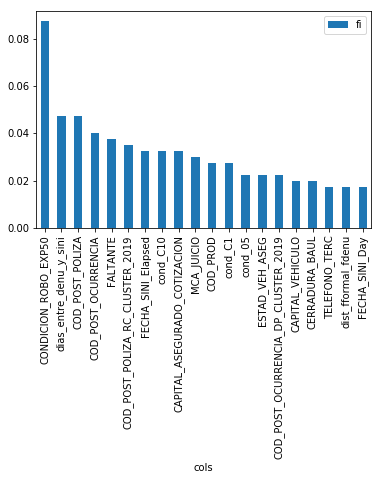

In [67]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [68]:
to_keep = list(rf_fi[rf_fi["fi"] >=0.005]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 60 of 152


In [69]:
"""to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "COD_CAUSA_SINI", 
            ] # "es_gte_5", "total_condicion", 

for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep"""

'to_remove = [\'COD_POST_POLIZA_RT_CLUSTER_2019\', \'COD_POST_OCURRENCIA_RT_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_RC_CLUSTER_2019\',  \'COD_POST_POLIZA_RC_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_DP_CLUSTER_2019\', \'COD_POST_POLIZA_DP_CLUSTER_2019\',\n             "COD_CAUSA_SINI", \n            ] # "es_gte_5", "total_condicion", \n\nfor col in to_remove:\n    if(col in to_keep):\n        to_keep.remove(col)\nto_keep'

In [55]:
# best model
clf.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 10},
           criterion='gini', max_depth=10, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=15,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [70]:
X_train_red = X_train[to_keep].copy()

In [71]:
print(len(X_train_red.columns))

60


### Training again with less features

In [72]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(best_model.best_estimator_)
rf.fit(X_train_red, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan, n_estimators=60,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=2.5,
              seed=0, silent=True, subsample=1)

In [73]:
y_val_pred = rf.predict(X_opt[to_keep])
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_opt, y_val_pred), roc_auc_score(y_opt, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.765237020316027, 0.6424036561264822)

In [74]:
confusion_matrix(y_opt, y_val_pred)

array([[185, 390],
       [ 26, 678]])

In [75]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
0,CONDICION_ROBO_EXP50,0.084184
1,dias_entre_denu_y_sini,0.058673
7,cond_C10,0.053571
9,MCA_JUICIO,0.045918
2,COD_POST_POLIZA,0.043367
4,FALTANTE,0.043367
5,COD_POST_POLIZA_RC_CLUSTER_2019,0.038265
15,CAPITAL_VEHICULO,0.035714
3,COD_POST_OCURRENCIA,0.033163
6,FECHA_SINI_Elapsed,0.030612


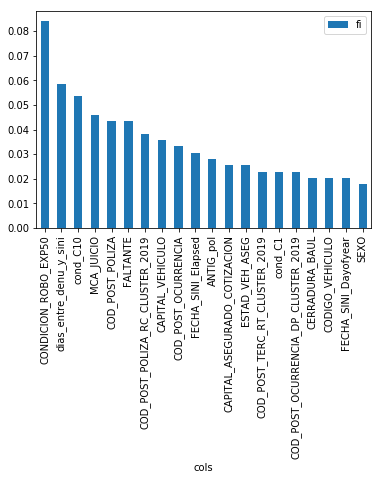

In [76]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
# best columns used
rf_fi["cols"].values

# final model

In [ ]:
# reset_rf_samples()

## full features final model

In [39]:
rf_full = copy(best_model.best_estimator_)
rf_full.fit(X_full_train, y_full_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=10, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=7, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [40]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.746, 0.738


In [41]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[118, 145],
       [ 39, 270]])

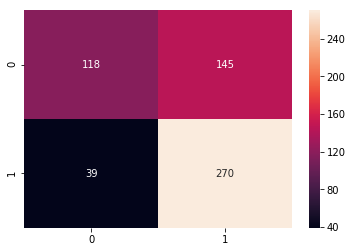

In [42]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## red features final model

In [126]:
rf_full = copy(best_model.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 1.5},
               colsample_bytree=0.5, importance_type='split', learning_rate=0.1,
               max_depth=None, min_child_samples=11, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [127]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.687, 0.696


In [128]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[155, 108],
       [ 91, 218]])

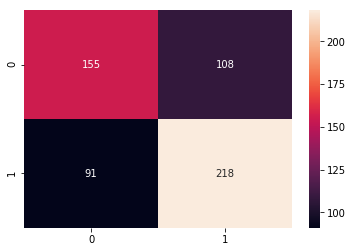

In [129]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador (sum cond >=5) comparison

In [81]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.6376811594202898,0.6036583114917495)


In [82]:
conf_mat = confusion_matrix(y_val, y_tronador)
conf_mat

array([[149, 114],
       [111, 198]])

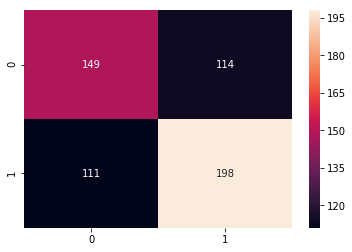

In [83]:
sns.heatmap(conf_mat, annot=True, fmt="d")

# Saving final model & columns used into hard drive

In [51]:
path_to_save = "../../src/models/1.1 - df_train 01-18to12-18/"
model_file = os.path.join(path_to_save, f"{model_id}(Model) - Model Optimization {metric} - class_weight {(rf_full.class_weight[0], rf_full.class_weight[1])} - time sorted - valid score ({metric_results}).pickle")

with open(model_file, "wb") as f:
    pickle.dump(rf_full, f, pickle.HIGHEST_PROTOCOL)

In [52]:
# save file for humans
# model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model for humans - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

# with open(model_file, "wb") as f:
#    pickle.dump(rf_full, f, 0) # 0 is human readable format

In [53]:
# merging list input & target
full_cols = list(to_keep)  # + ["EXISTE_FRAUDE"]
print(full_cols)

['cond_C10', 'TIPO_EXPED', 'preg_15', 'es_gte_5', 'preg_31', 'preg_33', 'cond_32', 'preg_32', 'cond_C11', 'cond_C12', 'cond_C2', 'METRO', 'SEXO_TERC', 'OCUPACION_ASEG', 'FALTANTE', 'preg_34', 'cond_C5']


In [54]:
path_to_save = "../../src/features/1.1 - df_train 01-18to12-18/"
columns_file = os.path.join(path_to_save, f"{model_id} (COLUMNS) - features: {len(full_cols)}.pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [81]:
# saving to use as example a few rows to implement the model
# path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
# sample_file = os.path.join(path_to_save, f"{model_id} (sample)  - dataset example to predict model.csv")

# df_example = X_val.loc[:, to_keep][-50:]
# df_example["EXISTE_FRAUDE"] = y_val[-50:]
# df_example.to_csv(sample_file)

In [ ]:
# df_example.head()

# Test prediction

In [58]:
df_test = pd.read_feather(os.path.join(path, "1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [59]:
# Loding the model

def load_model(file_name):
    """Load the dump model."""
    folder = "models"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    model_file = os.path.join(path_to_load, file_name)

    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(file_name):
    """Load the array of columns use in the dump model."""
    folder = "features"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    columns_file = os.path.join(path_to_load, file_name)

    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [47]:
model_name = "1.1.b.2.f(Model) - Model Optimization recall - class_weight (1, 18) - time sorted - valid score (0.403, 0.972).pickle"
columns_name = "1.1.b.2.f (COLUMNS) - features: 17.pickle"
m = load_model(model_name)
columns = load_columns(columns_name)

In [60]:
X_test = df_test[X_train.columns]
y_test = df_test["EXISTE_FRAUDE"]

In [61]:
X_test.head()

,cond_04,cond_05,cond_06,cond_09,cond_11,cond_12,cond_32,cond_37,cond_C1,cond_C10,cond_C11,cond_C12,cond_C13,cond_C14,cond_C15,cond_C16,cond_C17,cond_C18,cond_C19,cond_C2,cond_C20,cond_C21,cond_C3,cond_C4,cond_C5,cond_C6,cond_C7,cond_C8,cond_C9,total_condicion,es_gte_5,preg_1,preg_2,preg_3,preg_4,preg_5,preg_6,preg_7,preg_8,preg_9,preg_10,preg_11,preg_12,preg_15,preg_16,preg_18,preg_19,preg_22,preg_24,preg_27,preg_28,preg_30,preg_31,preg_32,preg_33,preg_34,preg_36,preg_37,CATASTROFICO,CERRADURA_BAUL,CERRADURA_DERECHA,CERRADURA_IZQUIERDA,CODIGO_BAJA,CODIGO_CARATULA,CODIGO_REAPERTURA,CODIGO_VEHICULO,COD_CAUSA_SINI,COD_POST_OCURRENCIA,COD_POST_POLIZA,COD_POST_TERC,COD_RAMO_sini,COD_RIES_sini,CONDICION_ROBO_EXP50,DANOS_MATERIALES,DESCRIPCION_TIPO,ESTADO_CIVIL,ESTADO_CIVIL_TERC,ESTAD_VEH_ASEG,FALTANTE,MCA_COASEG,MCA_JUICIO,MCA_VIP,METRO,OCUPACION_ASEG,SEXO,SEXO_TERC,TELEFONO_TERC,TIPO,TIPO_EXPED,TIPO_LESION,TIPO_LESION_MAXIMA,TIPO_SINIESTRO,USO,dias_entre_denu_y_sini,dist_fformal_fsini,dist_fformal_fdenu,existe_FECHA_FORMAL,CANT_RENOVACION,CAPITAL_ACCESORIOS,CAPITAL_ASEGURADO_COTIZACION,CAPITAL_VEHICULO,COD_COBRO,COD_COBRO_ANTERIOR,COD_PROD,COD_ZONA_CASCO,COD_ZONA_RC,COD_ZONA_ROBO,CONV_COMISIONARIO,CIF_ID,MCA_AGRAVANTE,MCA_EMPLEADO,MCA_MOVIMIENTO,MCA_POLIZA_VIP,NEGOCIO,PRENDARIO,SEGMENTO,cambio_cobro,ANTIG_pol,COD_EST_CIVIL,TIPO_ACTIVIDAD,CLIENTE,CODIGO_NACION,DATECO_TIPO_ACTIVIDAD,DOMICILIO_CODIGO_POSTAL,HABILITADO,FECHA_SINI_Year,FECHA_SINI_Month,FECHA_SINI_Week,FECHA_SINI_Day,FECHA_SINI_Dayofweek,FECHA_SINI_Dayofyear,FECHA_SINI_Is_month_end,FECHA_SINI_Is_month_start,FECHA_SINI_Is_quarter_end,FECHA_SINI_Is_quarter_start,FECHA_SINI_Is_year_end,FECHA_SINI_Is_year_start,FECHA_SINI_Hour,FECHA_SINI_Minute,FECHA_SINI_Second,FECHA_SINI_Elapsed,cant_pol,cant_sini_1y,COD_POST_POLIZA_DP_CLUSTER_2019,COD_POST_POLIZA_RT_CLUSTER_2019,COD_POST_POLIZA_RC_CLUSTER_2019,COD_POST_OCURRENCIA_DP_CLUSTER_2019,COD_POST_OCURRENCIA_RT_CLUSTER_2019,COD_POST_OCURRENCIA_RC_CLUSTER_2019,COD_POST_TERC_DP_CLUSTER_2019,COD_POST_TERC_RT_CLUSTER_2019,COD_POST_TERC_RC_CLUSTER_2019
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,-1.0,-1.0,-1.0,18380.0,226.0,1439.0,1439.0,-1.0,1.0,1.0,-1.0,0,3,0,-1,5.0,1,0,-1,1,1,44.0,1,-1,-1,3.0,3,-1,-1,5,1.0,0.0,-1.0,-1.0,0,24.0,8,2293,4514,0,0,73747.0,1.0,1.0,3.0,23,-1.0,0,0,-1,1,21,0,5,0,699.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1554076800,0.0,0.0,28.0,8.0,26.0,28.0,8.0,26.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,-1.0,-1.0,-1.0,6846.0,226.0,1708.0,1684.0,-1.0,1.0,1.0,-1.0,0,3,0,-1,3.0,1,0,-1,1,1,5.0,1,-1,-1,3.0,3,-1,-1,5,1.0,0.0,-1.0,-1.0,0,41.0,8,1985,3913,0,0,5350.0,1.0,1.0,1.0,107,-1.0,0,0,-1,1,21,0,4,0,1216.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1554076800,0.0,0.0,25.0,8.0,26.0,25.0,8.0,26.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,4.0,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4,-1,0,-1,-1,-1,-1,121,133,1,-1,1,-1,-1,-1,-1,0,-1,-1,-1,-1.0,-1.0,-1.0,2605.0,202.0,1678.0,1407.0,-1.0,1.0,1.0,1.0,0,3,6,-1,3.0,1,0,-1,0,1,44.0,1,-1,-1,3.0,5,-1,-1,6,1.0,0.0,-1.0,-1.0,0,1.0,8,433,674,5,-1,73761.0,1.0,1.0,3.0,38,-1.0,0,0,0,0,43,0,4,0,0.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1554076800,0.0,0.0,25.0,5.0,22.0,27.0,6.0,24.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,

## Model in test

In [64]:
# using trained model
y_test_pred_prob = best_model.predict_proba(X_test)[:, -1]

# Using load model
# y_test_pred_prob = m.predict_proba(X_test)[:, -1]

print("%.3f, %.3f" % (f1_score(y_test, y_test_pred_prob > 0.5), roc_auc_score(y_test, y_test_pred_prob)))

0.021, 0.921


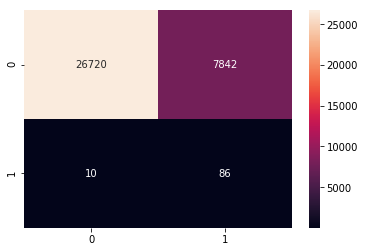

In [65]:
conf_mat = confusion_matrix(y_test, y_test_pred_prob > 0.5)
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador in test

In [63]:
y_tronador = X_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))

0.330, 0.851


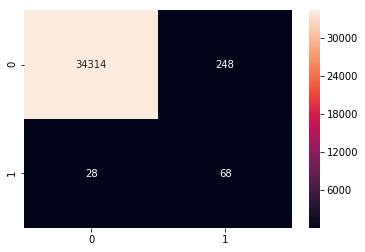

In [64]:
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")